In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the TSV dataset
df = pd.read_csv('English-Hindi.tsv', sep='\t', header=None, names=["id1", "en", "id2", "hi"])

In [3]:
# Show a sample
df.sample(5)

,id1,en,id2,hi
3962,453893,Don't open your book.,491015,अपनी किताब मत खोलो।
10116,4319732,"The next day, I bought a jackfruit.",4319700,अगले दिन मैंने एक कटहल खरीद लिया।
6487,3066298,You can't read a story if you don't understand.,3066310,"अगर तुम समजोगे नहीं, तो तुम वार्ता पढ़ नहीं सकते"
1699,242628,His behavior is very odd today.,514149,उसका बर्ताव आज बहुत अजीब है।
3390,317019,She is two years younger than me.,484047,वह मुझसे दो साल छोटी है।


In [4]:
# Keep only the English and Hindi columns
df = df[["en", "hi"]]

In [5]:
# Drop any rows with missing data
df.dropna(inplace=True)

In [6]:
# Reset index
df.reset_index(drop=True, inplace=True)

In [7]:
# Preview cleaned data
df.head()

,en,hi
0,Muiriel is 20 now.,म्यूरियल अब बीस साल की हो गई है।
1,Muiriel is 20 now.,म्यूरियल अब बीस साल की है।
2,Education in this world disappoints me.,मैं इस दुनिया में शिक्षा पर बहुत निराश हूँ।
3,That won't happen.,वैसा नहीं होगा।
4,I miss you.,मुझें तुम्हारी याद आ रही है।


In [8]:
# Number of sentence pairs
print("Total pairs:", len(df))

Total pairs: 13186


In [9]:
# Sentence length distributions
df["en_len"] = df["en"].apply(lambda x: len(x.split()))
df["hi_len"] = df["hi"].apply(lambda x: len(x.split()))

In [10]:
print("\nEnglish Sentence Length Stats:")
print(df["en_len"].describe())


English Sentence Length Stats:
count    13186.000000
mean         5.607614
std          2.676713
min          1.000000
25%          4.000000
50%          5.000000
75%          7.000000
max         53.000000
Name: en_len, dtype: float64


In [11]:
print("\nHindi Sentence Length Stats:")
print(df["hi_len"].describe())


Hindi Sentence Length Stats:
count    13186.000000
mean         6.277719
std          2.999823
min          1.000000
25%          4.000000
50%          6.000000
75%          8.000000
max         57.000000
Name: hi_len, dtype: float64


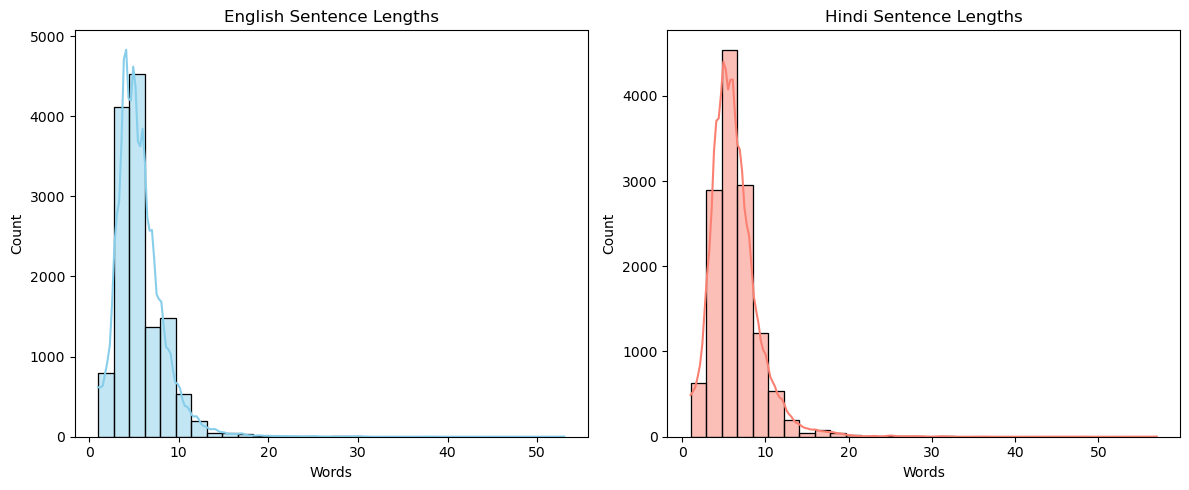

In [12]:
plt.figure(figsize=(12, 5))

# English
plt.subplot(1, 2, 1)
sns.histplot(df["en_len"], bins=30, kde=True, color='skyblue')
plt.title("English Sentence Lengths")
plt.xlabel("Words")

# Hindi
plt.subplot(1, 2, 2)
sns.histplot(df["hi_len"], bins=30, kde=True, color='salmon')
plt.title("Hindi Sentence Lengths")
plt.xlabel("Words")

plt.tight_layout()
plt.show()

In [13]:
for i in range(5):
    print(f"EN: {df.loc[i, 'en']}")
    print(f"HI: {df.loc[i, 'hi']}")
    print("---")

EN: Muiriel is 20 now.
HI: म्यूरियल अब बीस साल की हो गई है।
---
EN: Muiriel is 20 now.
HI: म्यूरियल अब बीस साल की है।
---
EN: Education in this world disappoints me.
HI: मैं इस दुनिया में शिक्षा पर बहुत निराश हूँ।
---
EN: That won't happen.
HI: वैसा नहीं होगा।
---
EN: I miss you.
HI: मुझें तुम्हारी याद आ रही है।
---


In [14]:
def tokenize(sentence):
    return sentence.lower().strip().split()

In [15]:
from collections import Counter
import itertools

In [16]:
class Vocabulary:
    def __init__(self, freq_threshold=2):
        self.freq_threshold = freq_threshold
        self.itos = {0: "<pad>", 1: "<sos>", 2: "<eos>", 3: "<unk>"}
        self.stoi = {"<pad>": 0, "<sos>": 1, "<eos>": 2, "<unk>": 3}
        self.idx = 4

    def build_vocab(self, sentence_list):
        frequencies = Counter()
        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                frequencies[word] += 1

        for word, freq in frequencies.items():
            if freq >= self.freq_threshold:
                self.stoi[word] = self.idx
                self.itos[self.idx] = word
                self.idx += 1

    def tokenize(self, sentence):
        return sentence.lower().strip().split()

    def numericalize(self, sentence):
        tokens = self.tokenize(sentence)
        return [self.stoi.get(token, self.stoi["<unk>"]) for token in tokens]

    def __len__(self):
        return len(self.stoi)

    def __getitem__(self, token):
        return self.stoi.get(token, self.stoi["<unk>"])

In [17]:
# Create vocab instances
en_vocab = Vocabulary(freq_threshold=2)
hi_vocab = Vocabulary(freq_threshold=2)

In [18]:
# Build vocabs
en_vocab.build_vocab(df["en"].tolist())
hi_vocab.build_vocab(df["hi"].tolist())

In [19]:
print(f"English vocab size: {len(en_vocab.stoi)}")
print(f"Hindi vocab size: {len(hi_vocab.stoi)}")

English vocab size: 4117
Hindi vocab size: 4044


In [20]:
def encode_sentence(sentence, vocab, max_len=50):
    tokens = [vocab.stoi["<sos>"]] + vocab.numericalize(sentence)[:max_len-2] + [vocab.stoi["<eos>"]]
    return tokens + [vocab.stoi["<pad>"]] * (max_len - len(tokens))

In [21]:
sample_en = "That won't happen."
sample_hi = "वैसा नहीं होगा।"

In [22]:
print("Encoded English:", encode_sentence(sample_en, en_vocab))
print("Encoded Hindi:", encode_sentence(sample_hi, hi_vocab))

Encoded English: [1, 13, 14, 15, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Encoded Hindi: [1, 21, 22, 23, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [23]:
import torch
import torch.nn as nn
import math

In [24]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [25]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size(-1)
    scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)

    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)

    attention = torch.softmax(scores, dim=-1)
    return torch.matmul(attention, v), attention

In [26]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.query_linear = nn.Linear(d_model, d_model)
        self.key_linear = nn.Linear(d_model, d_model)
        self.value_linear = nn.Linear(d_model, d_model)

        self.out_linear = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(0.1)

    def forward(self, q, k, v, mask=None):
        batch_size = q.size(0)

        # Project Q, K, V
        Q = self.query_linear(q)  # [B, T, D]
        K = self.key_linear(k)
        V = self.value_linear(v)

        # Reshape and transpose: [B, T, D] -> [B, H, T, Dk]
        Q = Q.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)  # [B, H, T, Dk]
        K = K.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = V.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        # Apply scaled dot-product attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.d_k ** 0.5)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        attention_weights = torch.softmax(scores, dim=-1)
        attention_output = torch.matmul(self.dropout(attention_weights), V)  # [B, H, T, Dk]

        # Concatenate heads: [B, H, T, Dk] -> [B, T, H * Dk]
        attention_output = attention_output.transpose(1, 2).contiguous() \
                                            .view(batch_size, -1, self.d_model)

        return self.out_linear(attention_output)

In [27]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=2048, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.linear2(self.dropout(self.relu(self.linear1(x))))

In [28]:
class LayerNorm(nn.Module):
    def __init__(self, d_model, eps=1e-6):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(d_model))
        self.beta = nn.Parameter(torch.zeros(d_model))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta

In [29]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.ffn = FeedForward(d_model, d_ff, dropout)
        self.norm1 = LayerNorm(d_model)
        self.norm2 = LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        x = self.norm1(x + self.dropout(self.self_attn(x, x, x, mask)))
        x = self.norm2(x + self.dropout(self.ffn(x)))
        return x

In [30]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.ffn = FeedForward(d_model, d_ff, dropout)

        self.norm1 = LayerNorm(d_model)
        self.norm2 = LayerNorm(d_model)
        self.norm3 = LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_out, src_mask=None, tgt_mask=None):
        x = self.norm1(x + self.dropout(self.self_attn(x, x, x, tgt_mask)))
        x = self.norm2(x + self.dropout(self.cross_attn(x, enc_out, enc_out, src_mask)))
        x = self.norm3(x + self.dropout(self.ffn(x)))
        return x

In [31]:
class Encoder(nn.Module):
    def __init__(self, input_vocab_size, d_model, num_layers, num_heads, d_ff, max_len, dropout=0.1):
        super().__init__()
        self.embed = nn.Embedding(input_vocab_size, d_model)
        self.pos_enc = PositionalEncoding(d_model, max_len)
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        x = self.embed(x)
        x = self.pos_enc(x)
        x = self.dropout(x)

        for layer in self.layers:
            x = layer(x, mask)

        return x

In [32]:
class Decoder(nn.Module):
    def __init__(self, target_vocab_size, d_model, num_layers, num_heads, d_ff, max_len, dropout=0.1):
        super().__init__()
        self.embed = nn.Embedding(target_vocab_size, d_model)
        self.pos_enc = PositionalEncoding(d_model, max_len)
        self.layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_out, src_mask=None, tgt_mask=None):
        x = self.embed(x)
        x = self.pos_enc(x)
        x = self.dropout(x)

        for layer in self.layers:
            x = layer(x, enc_out, src_mask, tgt_mask)

        return x

In [33]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=512, num_layers=6, num_heads=8, d_ff=2048, max_len=100, dropout=0.1):
        super().__init__()
        self.encoder = Encoder(src_vocab_size, d_model, num_layers, num_heads, d_ff, max_len, dropout)
        self.decoder = Decoder(tgt_vocab_size, d_model, num_layers, num_heads, d_ff, max_len, dropout)
        self.fc_out = nn.Linear(d_model, tgt_vocab_size)

    def make_pad_mask(self, seq, pad_idx):
        return (seq != pad_idx).unsqueeze(1).unsqueeze(2)  # [B, 1, 1, T]

    def make_subsequent_mask(self, size):
        return torch.tril(torch.ones((size, size))).bool().to(next(self.parameters()).device)

    def forward(self, src, tgt, src_pad_idx, tgt_pad_idx):
        src_mask = self.make_pad_mask(src, src_pad_idx)
        tgt_pad_mask = self.make_pad_mask(tgt, tgt_pad_idx)
        tgt_sub_mask = self.make_subsequent_mask(tgt.size(1))
        tgt_mask = tgt_pad_mask & tgt_sub_mask  # Combine masks

        enc_out = self.encoder(src, src_mask)
        dec_out = self.decoder(tgt, enc_out, src_mask, tgt_mask)

        out = self.fc_out(dec_out)
        return out

In [34]:
from torch.utils.data import Dataset

In [35]:
class TranslationDataset(Dataset):
    def __init__(self, df, en_vocab, hi_vocab, max_len=50):
        self.en_sentences = df["en"].tolist()
        self.hi_sentences = df["hi"].tolist()
        self.en_vocab = en_vocab
        self.hi_vocab = hi_vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.en_sentences)

    def __getitem__(self, idx):
        src = encode_sentence(self.en_sentences[idx], self.en_vocab, self.max_len)
        tgt = encode_sentence(self.hi_sentences[idx], self.hi_vocab, self.max_len)
        return torch.tensor(src), torch.tensor(tgt)

In [36]:
def collate_fn(batch):
    src_batch, tgt_batch = zip(*batch)
    
    src_batch = torch.stack(src_batch)
    tgt_batch = torch.stack(tgt_batch)

    # Transformer decoder needs: tgt_input (without <eos>) and tgt_output (without <sos>)
    tgt_input = tgt_batch[:, :-1]
    tgt_output = tgt_batch[:, 1:]

    return src_batch, tgt_input, tgt_output

In [37]:
from torch.utils.data import DataLoader

In [38]:
BATCH_SIZE = 32
MAX_LEN = 50

In [39]:
dataset = TranslationDataset(df, en_vocab, hi_vocab, max_len=MAX_LEN)
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

In [40]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

In [41]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {DEVICE}")

Using Device: cuda


In [42]:
# Hyperparams
SRC_PAD_IDX = en_vocab["<pad>"]
TGT_PAD_IDX = hi_vocab["<pad>"]
NUM_EPOCHS = 100
D_MODEL = 512

In [43]:
model = Transformer(
    src_vocab_size=len(en_vocab),
    tgt_vocab_size=len(hi_vocab),
    d_model=D_MODEL,
    num_layers=6,
    num_heads=8,
    d_ff=2048,
    max_len=MAX_LEN,
    dropout=0.1
).to(DEVICE)

In [44]:
criterion = nn.CrossEntropyLoss(ignore_index=TGT_PAD_IDX)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [45]:
import os

In [46]:
def save_checkpoint(epoch, model, optimizer, loss, path="checkpoint.pt"):
    torch.save({
        'epoch': epoch,
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'loss': loss
    }, path)

    print(f"Checkpoint saved at epoch {epoch}, loss {loss:.4f}.")

In [47]:
import torch

def load_checkpoint(model, optimizer, path="checkpoint.pt"):
    if torch.cuda.is_available() and path is not None and os.path.exists(path):
        checkpoint = torch.load(path)
    elif path is not None and os.path.exists(path):
        checkpoint = torch.load(path, map_location=torch.device('cpu'))
    else:
        print(f"No checkpoint found at {path}. Starting from scratch.")
        return 0

    model.load_state_dict(checkpoint['model_state'])
    optimizer.load_state_dict(checkpoint['optimizer_state'])

    epoch = checkpoint['epoch']
    loss = checkpoint['loss']

    print(f"✅ Loaded checkpoint from epoch {epoch} with loss {loss:.4f}")
    
    return epoch

In [48]:
def train(model, train_loader, optimizer, criterion, start_epoch=0, num_epochs=NUM_EPOCHS, checkpoint_path="checkpoint.pt"):
    for epoch in range(start_epoch, num_epochs):
        model.train()
        epoch_loss = 0
        loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")

        for src, tgt_input, tgt_output in loop:
            src, tgt_input, tgt_output = src.to(DEVICE), tgt_input.to(DEVICE), tgt_output.to(DEVICE)

            output = model(src, tgt_input, SRC_PAD_IDX, TGT_PAD_IDX)
            output = output.view(-1, output.shape[-1])
            tgt_output = tgt_output.view(-1)

            loss = criterion(output, tgt_output)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        # Save checkpoint at end of each epoch
        save_checkpoint(epoch+1, model, optimizer, epoch_loss / len(train_loader), checkpoint_path)

In [49]:
start_epoch = load_checkpoint(model, optimizer)

No checkpoint found at checkpoint.pt. Starting from scratch.


In [50]:
train(model, train_loader, optimizer, criterion, start_epoch=start_epoch)

Epoch [1/100]: 100%|██████████| 413/413 [01:14<00:00,  5.57it/s, loss=3.41]


Checkpoint saved at epoch 1, loss 4.9733.


Epoch [2/100]: 100%|██████████| 413/413 [01:22<00:00,  5.00it/s, loss=2.23]


Checkpoint saved at epoch 2, loss 3.7879.


Epoch [3/100]: 100%|██████████| 413/413 [01:18<00:00,  5.25it/s, loss=1.23]


Checkpoint saved at epoch 3, loss 3.1634.


Epoch [4/100]: 100%|██████████| 413/413 [00:53<00:00,  7.71it/s, loss=2.56]


Checkpoint saved at epoch 4, loss 2.6815.


Epoch [5/100]: 100%|██████████| 413/413 [01:14<00:00,  5.53it/s, loss=2.79]


Checkpoint saved at epoch 5, loss 2.2675.


Epoch [6/100]: 100%|██████████| 413/413 [01:27<00:00,  4.70it/s, loss=1.81]


Checkpoint saved at epoch 6, loss 1.9130.


Epoch [7/100]: 100%|██████████| 413/413 [01:28<00:00,  4.66it/s, loss=1.39]


Checkpoint saved at epoch 7, loss 1.5927.


Epoch [8/100]: 100%|██████████| 413/413 [01:45<00:00,  3.90it/s, loss=1.81] 


Checkpoint saved at epoch 8, loss 1.3146.


Epoch [9/100]: 100%|██████████| 413/413 [01:47<00:00,  3.85it/s, loss=1.47] 


Checkpoint saved at epoch 9, loss 1.1017.


Epoch [10/100]: 100%|██████████| 413/413 [01:00<00:00,  6.87it/s, loss=0.844]


Checkpoint saved at epoch 10, loss 0.8854.


Epoch [11/100]: 100%|██████████| 413/413 [01:01<00:00,  6.67it/s, loss=0.336]


Checkpoint saved at epoch 11, loss 0.7204.


Epoch [12/100]: 100%|██████████| 413/413 [01:23<00:00,  4.94it/s, loss=0.871]


Checkpoint saved at epoch 12, loss 0.5910.


Epoch [13/100]: 100%|██████████| 413/413 [01:14<00:00,  5.58it/s, loss=0.954]


Checkpoint saved at epoch 13, loss 0.4916.


Epoch [14/100]: 100%|██████████| 413/413 [01:11<00:00,  5.79it/s, loss=0.458]


Checkpoint saved at epoch 14, loss 0.4132.


Epoch [15/100]: 100%|██████████| 413/413 [01:23<00:00,  4.93it/s, loss=0.584]


Checkpoint saved at epoch 15, loss 0.3546.


Epoch [16/100]: 100%|██████████| 413/413 [01:21<00:00,  5.04it/s, loss=0.421]


Checkpoint saved at epoch 16, loss 0.3217.


Epoch [17/100]: 100%|██████████| 413/413 [01:08<00:00,  6.04it/s, loss=0.382]


Checkpoint saved at epoch 17, loss 0.2910.


Epoch [18/100]: 100%|██████████| 413/413 [00:53<00:00,  7.79it/s, loss=0.105]


Checkpoint saved at epoch 18, loss 0.2679.


Epoch [19/100]: 100%|██████████| 413/413 [00:52<00:00,  7.92it/s, loss=0.107]


Checkpoint saved at epoch 19, loss 0.2457.


Epoch [20/100]: 100%|██████████| 413/413 [00:56<00:00,  7.36it/s, loss=0.625]


Checkpoint saved at epoch 20, loss 0.2378.


Epoch [21/100]: 100%|██████████| 413/413 [00:51<00:00,  8.01it/s, loss=0.489]


Checkpoint saved at epoch 21, loss 0.2295.


Epoch [22/100]: 100%|██████████| 413/413 [00:52<00:00,  7.80it/s, loss=0.36] 


Checkpoint saved at epoch 22, loss 0.2206.


Epoch [23/100]: 100%|██████████| 413/413 [00:52<00:00,  7.89it/s, loss=0.0705]


Checkpoint saved at epoch 23, loss 0.2116.


Epoch [24/100]: 100%|██████████| 413/413 [00:56<00:00,  7.25it/s, loss=0.0719]


Checkpoint saved at epoch 24, loss 0.2011.


Epoch [25/100]: 100%|██████████| 413/413 [00:51<00:00,  7.98it/s, loss=0.14] 


Checkpoint saved at epoch 25, loss 0.1971.


Epoch [26/100]: 100%|██████████| 413/413 [01:19<00:00,  5.20it/s, loss=0.0677]


Checkpoint saved at epoch 26, loss 0.1947.


Epoch [27/100]: 100%|██████████| 413/413 [00:58<00:00,  7.04it/s, loss=0.0324]


Checkpoint saved at epoch 27, loss 0.1932.


Epoch [28/100]: 100%|██████████| 413/413 [01:43<00:00,  3.98it/s, loss=0.106]


Checkpoint saved at epoch 28, loss 0.1884.


Epoch [29/100]: 100%|██████████| 413/413 [01:35<00:00,  4.34it/s, loss=0.731] 


Checkpoint saved at epoch 29, loss 0.1844.


Epoch [30/100]: 100%|██████████| 413/413 [01:22<00:00,  4.98it/s, loss=0.0783]


Checkpoint saved at epoch 30, loss 0.1823.


Epoch [31/100]: 100%|██████████| 413/413 [01:24<00:00,  4.87it/s, loss=0.206] 


Checkpoint saved at epoch 31, loss 0.1783.


Epoch [32/100]: 100%|██████████| 413/413 [01:24<00:00,  4.88it/s, loss=0.0226]


Checkpoint saved at epoch 32, loss 0.1745.


Epoch [33/100]: 100%|██████████| 413/413 [01:27<00:00,  4.74it/s, loss=0.179] 


Checkpoint saved at epoch 33, loss 0.1691.


Epoch [34/100]: 100%|██████████| 413/413 [01:25<00:00,  4.84it/s, loss=0.112] 


Checkpoint saved at epoch 34, loss 0.1676.


Epoch [35/100]: 100%|██████████| 413/413 [01:24<00:00,  4.87it/s, loss=0.148] 


Checkpoint saved at epoch 35, loss 0.1654.


Epoch [36/100]: 100%|██████████| 413/413 [01:27<00:00,  4.72it/s, loss=0.0911]


Checkpoint saved at epoch 36, loss 0.1624.


Epoch [37/100]: 100%|██████████| 413/413 [01:25<00:00,  4.83it/s, loss=0.137] 


Checkpoint saved at epoch 37, loss 0.1586.


Epoch [38/100]: 100%|██████████| 413/413 [01:21<00:00,  5.04it/s, loss=0.439] 


Checkpoint saved at epoch 38, loss 0.1580.


Epoch [39/100]: 100%|██████████| 413/413 [01:28<00:00,  4.67it/s, loss=0.156] 


Checkpoint saved at epoch 39, loss 0.1586.


Epoch [40/100]: 100%|██████████| 413/413 [01:27<00:00,  4.74it/s, loss=0.0561]


Checkpoint saved at epoch 40, loss 0.1546.


Epoch [41/100]: 100%|██████████| 413/413 [01:26<00:00,  4.79it/s, loss=0.0713]


Checkpoint saved at epoch 41, loss 0.1530.


Epoch [42/100]: 100%|██████████| 413/413 [01:24<00:00,  4.88it/s, loss=0.105] 


Checkpoint saved at epoch 42, loss 0.1512.


Epoch [43/100]: 100%|██████████| 413/413 [01:24<00:00,  4.86it/s, loss=0.0223]


Checkpoint saved at epoch 43, loss 0.1473.


Epoch [44/100]: 100%|██████████| 413/413 [01:25<00:00,  4.80it/s, loss=0.033] 


Checkpoint saved at epoch 44, loss 0.1473.


Epoch [45/100]: 100%|██████████| 413/413 [01:25<00:00,  4.84it/s, loss=0.242] 


Checkpoint saved at epoch 45, loss 0.1449.


Epoch [46/100]: 100%|██████████| 413/413 [01:25<00:00,  4.81it/s, loss=0.15]  


Checkpoint saved at epoch 46, loss 0.1444.


Epoch [47/100]: 100%|██████████| 413/413 [01:26<00:00,  4.80it/s, loss=0.0318]


Checkpoint saved at epoch 47, loss 0.1427.


Epoch [48/100]: 100%|██████████| 413/413 [01:24<00:00,  4.88it/s, loss=0.376] 


Checkpoint saved at epoch 48, loss 0.1414.


Epoch [49/100]: 100%|██████████| 413/413 [01:24<00:00,  4.87it/s, loss=0.00883]


Checkpoint saved at epoch 49, loss 0.1411.


Epoch [50/100]: 100%|██████████| 413/413 [01:24<00:00,  4.87it/s, loss=0.2]   


Checkpoint saved at epoch 50, loss 0.1385.


Epoch [51/100]: 100%|██████████| 413/413 [01:26<00:00,  4.75it/s, loss=0.0503]


Checkpoint saved at epoch 51, loss 0.1373.


Epoch [52/100]: 100%|██████████| 413/413 [01:24<00:00,  4.88it/s, loss=0.207] 


Checkpoint saved at epoch 52, loss 0.1374.


Epoch [53/100]: 100%|██████████| 413/413 [01:26<00:00,  4.79it/s, loss=0.0152]


Checkpoint saved at epoch 53, loss 0.1366.


Epoch [54/100]: 100%|██████████| 413/413 [01:26<00:00,  4.78it/s, loss=0.00926]


Checkpoint saved at epoch 54, loss 0.1340.


Epoch [55/100]: 100%|██████████| 413/413 [01:26<00:00,  4.78it/s, loss=0.335] 


Checkpoint saved at epoch 55, loss 0.1330.


Epoch [56/100]: 100%|██████████| 413/413 [01:24<00:00,  4.91it/s, loss=0.175] 


Checkpoint saved at epoch 56, loss 0.1337.


Epoch [57/100]: 100%|██████████| 413/413 [01:24<00:00,  4.91it/s, loss=0.327] 


Checkpoint saved at epoch 57, loss 0.1291.


Epoch [58/100]: 100%|██████████| 413/413 [01:25<00:00,  4.84it/s, loss=0.1]   


Checkpoint saved at epoch 58, loss 0.1302.


Epoch [59/100]: 100%|██████████| 413/413 [01:23<00:00,  4.95it/s, loss=0.283] 


Checkpoint saved at epoch 59, loss 0.1288.


Epoch [60/100]: 100%|██████████| 413/413 [01:25<00:00,  4.81it/s, loss=0.0353]


Checkpoint saved at epoch 60, loss 0.1280.


Epoch [61/100]: 100%|██████████| 413/413 [01:26<00:00,  4.76it/s, loss=0.0137]


Checkpoint saved at epoch 61, loss 0.1278.


Epoch [62/100]: 100%|██████████| 413/413 [01:25<00:00,  4.82it/s, loss=0.0374]


Checkpoint saved at epoch 62, loss 0.1247.


Epoch [63/100]: 100%|██████████| 413/413 [01:25<00:00,  4.84it/s, loss=0.00855]


Checkpoint saved at epoch 63, loss 0.1223.


Epoch [64/100]: 100%|██████████| 413/413 [01:25<00:00,  4.83it/s, loss=0.0885]


Checkpoint saved at epoch 64, loss 0.1244.


Epoch [65/100]: 100%|██████████| 413/413 [01:25<00:00,  4.84it/s, loss=0.137] 


Checkpoint saved at epoch 65, loss 0.1226.


Epoch [66/100]: 100%|██████████| 413/413 [01:23<00:00,  4.92it/s, loss=0.11]  


Checkpoint saved at epoch 66, loss 0.1218.


Epoch [67/100]: 100%|██████████| 413/413 [01:24<00:00,  4.89it/s, loss=0.00595]


Checkpoint saved at epoch 67, loss 0.1202.


Epoch [68/100]: 100%|██████████| 413/413 [01:25<00:00,  4.80it/s, loss=0.495] 


Checkpoint saved at epoch 68, loss 0.1201.


Epoch [69/100]: 100%|██████████| 413/413 [01:26<00:00,  4.78it/s, loss=0.0348]


Checkpoint saved at epoch 69, loss 0.1225.


Epoch [70/100]: 100%|██████████| 413/413 [01:24<00:00,  4.88it/s, loss=0.118] 


Checkpoint saved at epoch 70, loss 0.1179.


Epoch [71/100]: 100%|██████████| 413/413 [01:26<00:00,  4.79it/s, loss=0.117] 


Checkpoint saved at epoch 71, loss 0.1181.


Epoch [72/100]: 100%|██████████| 413/413 [01:25<00:00,  4.83it/s, loss=0.113] 


Checkpoint saved at epoch 72, loss 0.1144.


Epoch [73/100]: 100%|██████████| 413/413 [01:23<00:00,  4.93it/s, loss=0.194] 


Checkpoint saved at epoch 73, loss 0.1160.


Epoch [74/100]: 100%|██████████| 413/413 [01:25<00:00,  4.85it/s, loss=0.011] 


Checkpoint saved at epoch 74, loss 0.1177.


Epoch [75/100]: 100%|██████████| 413/413 [01:28<00:00,  4.69it/s, loss=0.0169]


Checkpoint saved at epoch 75, loss 0.1141.


Epoch [76/100]: 100%|██████████| 413/413 [01:26<00:00,  4.77it/s, loss=0.293] 


Checkpoint saved at epoch 76, loss 0.1132.


Epoch [77/100]: 100%|██████████| 413/413 [01:24<00:00,  4.86it/s, loss=0.555] 


Checkpoint saved at epoch 77, loss 0.1174.


Epoch [78/100]: 100%|██████████| 413/413 [01:24<00:00,  4.90it/s, loss=0.049] 


Checkpoint saved at epoch 78, loss 0.1127.


Epoch [79/100]: 100%|██████████| 413/413 [01:25<00:00,  4.83it/s, loss=0.205] 


Checkpoint saved at epoch 79, loss 0.1130.


Epoch [80/100]: 100%|██████████| 413/413 [01:25<00:00,  4.83it/s, loss=0.0646]


Checkpoint saved at epoch 80, loss 0.1101.


Epoch [81/100]: 100%|██████████| 413/413 [01:24<00:00,  4.87it/s, loss=0.143] 


Checkpoint saved at epoch 81, loss 0.1098.


Epoch [82/100]: 100%|██████████| 413/413 [01:26<00:00,  4.75it/s, loss=0.0469]


Checkpoint saved at epoch 82, loss 0.1114.


Epoch [83/100]: 100%|██████████| 413/413 [01:25<00:00,  4.83it/s, loss=0.00443]


Checkpoint saved at epoch 83, loss 0.1101.


Epoch [84/100]: 100%|██████████| 413/413 [01:26<00:00,  4.80it/s, loss=0.32]  


Checkpoint saved at epoch 84, loss 0.1113.


Epoch [85/100]: 100%|██████████| 413/413 [01:25<00:00,  4.81it/s, loss=0.0029]


Checkpoint saved at epoch 85, loss 0.1085.


Epoch [86/100]: 100%|██████████| 413/413 [01:27<00:00,  4.70it/s, loss=0.134] 


Checkpoint saved at epoch 86, loss 0.1069.


Epoch [87/100]: 100%|██████████| 413/413 [01:27<00:00,  4.74it/s, loss=0.127] 


Checkpoint saved at epoch 87, loss 0.1108.


Epoch [88/100]: 100%|██████████| 413/413 [01:26<00:00,  4.77it/s, loss=0.114] 


Checkpoint saved at epoch 88, loss 0.1107.


Epoch [89/100]: 100%|██████████| 413/413 [01:27<00:00,  4.71it/s, loss=0.137] 


Checkpoint saved at epoch 89, loss 0.1089.


Epoch [90/100]: 100%|██████████| 413/413 [01:28<00:00,  4.68it/s, loss=0.0495]


Checkpoint saved at epoch 90, loss 0.1076.


Epoch [91/100]: 100%|██████████| 413/413 [01:29<00:00,  4.63it/s, loss=0.0109]


Checkpoint saved at epoch 91, loss 0.1056.


Epoch [92/100]: 100%|██████████| 413/413 [01:27<00:00,  4.71it/s, loss=0.119] 


Checkpoint saved at epoch 92, loss 0.1051.


Epoch [93/100]: 100%|██████████| 413/413 [01:27<00:00,  4.72it/s, loss=0.387] 


Checkpoint saved at epoch 93, loss 0.1072.


Epoch [94/100]: 100%|██████████| 413/413 [01:27<00:00,  4.73it/s, loss=0.0169]


Checkpoint saved at epoch 94, loss 0.1061.


Epoch [95/100]: 100%|██████████| 413/413 [01:27<00:00,  4.73it/s, loss=0.000623]


Checkpoint saved at epoch 95, loss 0.1033.


Epoch [96/100]: 100%|██████████| 413/413 [01:25<00:00,  4.82it/s, loss=0.681] 


Checkpoint saved at epoch 96, loss 0.1074.


Epoch [97/100]: 100%|██████████| 413/413 [01:38<00:00,  4.21it/s, loss=0.00199]


Checkpoint saved at epoch 97, loss 0.1086.


Epoch [98/100]: 100%|██████████| 413/413 [01:06<00:00,  6.21it/s, loss=0.103] 


Checkpoint saved at epoch 98, loss 0.1030.


Epoch [99/100]: 100%|██████████| 413/413 [00:57<00:00,  7.14it/s, loss=0.00126]


Checkpoint saved at epoch 99, loss 0.1013.


Epoch [100/100]: 100%|██████████| 413/413 [00:57<00:00,  7.20it/s, loss=0.0111]


Checkpoint saved at epoch 100, loss 0.1017.


In [51]:
def translate_sentence(model, sentence, en_vocab, hi_vocab, max_len=50):
    model.eval()
    tokens = encode_sentence(sentence, en_vocab, max_len=max_len)
    src_tensor = torch.tensor(tokens).unsqueeze(0).to(DEVICE)

    tgt_tokens = [hi_vocab["<sos>"]]
    for _ in range(max_len):
        tgt_tensor = torch.tensor(tgt_tokens).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            output = model(src_tensor, tgt_tensor, SRC_PAD_IDX, TGT_PAD_IDX)
        next_token = output[0, -1].argmax().item()
        tgt_tokens.append(next_token)
        if next_token == hi_vocab["<eos>"]:
            break

    translated = [hi_vocab.itos[idx] for idx in tgt_tokens[1:-1]]
    return ' '.join(translated)

In [52]:
example_sentences = [
    "I love you.",
    "What is your name?",
    "How are you?",
    "The weather is nice today.",
    "She is a good teacher."
]

In [53]:
for sentence in example_sentences:
    translation = translate_sentence(model, sentence, en_vocab, hi_vocab)
    print(f"\n🗣 English: {sentence}")
    print(f"🇮🇳 Hindi: {translation}")


🗣 English: I love you.
🇮🇳 Hindi: मैं तुमसे प्यार करता हूँ।

🗣 English: What is your name?
🇮🇳 Hindi: तुम्हारा नाम क्या है?

🗣 English: How are you?
🇮🇳 Hindi: आप कैसे हैं?

🗣 English: The weather is nice today.
🇮🇳 Hindi: आज मौसम अच्छा है।

🗣 English: She is a good teacher.
🇮🇳 Hindi: वह एक अच्छी अध्यापिका है.


In [54]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction

In [55]:
smoothie = SmoothingFunction().method4

In [56]:
def evaluate_bleu_nltk(model, dataset, en_vocab, hi_vocab, max_len=50):
    references = []
    hypotheses = []

    for en_sentence, hi_sentence in dataset:
        pred = translate_sentence(model, en_sentence, en_vocab, hi_vocab, max_len)
        pred_tokens = pred.split()
        ref_tokens = hi_sentence.split()

        references.append([ref_tokens])   # list of reference lists
        hypotheses.append(pred_tokens)    # list of predicted tokens

    score = corpus_bleu(references, hypotheses, smoothing_function=smoothie)
    print(f"🌐 BLEU Score (NLTK): {score * 100:.2f}")
    return score

In [57]:
val_dataset = [
    ("I love you.", "मैं तुमसे प्यार करता हूँ।"),
    ("How are you?", "आप कैसे हैं?"),
    ("You should sleep.", "आपको सोना चाहिए।"),
    ("Maybe Tom doesn't love you.", "टॉम शायद तुमसे प्यार नहीं करता है।"),
    ("Let me tell Tom.","मुझे टॉम को बताने दीजिए।")
]

In [58]:
evaluate_bleu_nltk(model, val_dataset, en_vocab, hi_vocab)

🌐 BLEU Score (NLTK): 77.88


0.7788079465921698

In [59]:
# Save the model weights
torch.save(model.state_dict(), "transformer_translation_final.pth")

# Save vocab mappings (example using pickle)
import pickle
with open("en_vocab.pkl", "wb") as f:
    pickle.dump(en_vocab, f)

with open("hi_vocab.pkl", "wb") as f:
    pickle.dump(hi_vocab, f)

print("✅ Model and vocabs saved.")

✅ Model and vocabs saved.
